# 이미지분석_사진유사도비교_서비스_mefiapipe_deepface

In [53]:
# 이미지 유사도 분석 모델 다운로드 
!wget -O embedder.tflite -q https://storage.googleapis.com/mediapipe-models/image_embedder/mobilenet_v3_small/float32/1/mobilenet_v3_small.tflite

In [54]:
import urllib
import cv2
import math
import matplotlib.pyplot as plt

In [55]:
image_filenames = ['burger.jpg', 'burger_crop.jpg']

for name in image_filenames:
    url = f"http://storage.googleapis.com/mediapipe-assets/{name}"
    urllib.request.urlretrieve(url, name)

In [56]:
desired_height = 480
desired_width = 480

In [57]:
def resize_and_show(image):
    h, w = image.shape[:2]
    if h > w:
        img = cv2.resize(image, (desired_width,math.floor(h/(w/desired_width))))
    else:
        img = cv2.resize(image, (math.floor(w/(h/desired_height)), desired_height))
    return img

burger.jpg


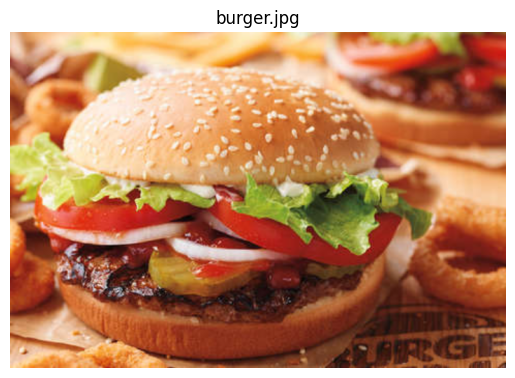

burger_crop.jpg


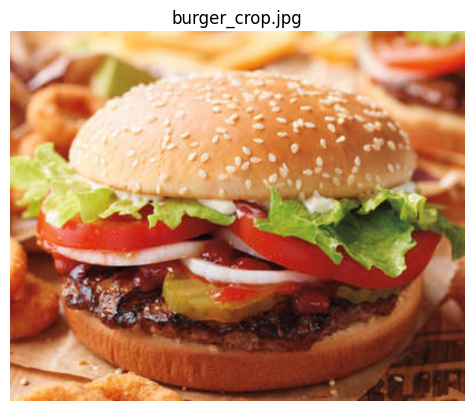

In [58]:
# 이미지 미리보기
images = {name:cv2.imread(name) for name in image_filenames}
for name, image in images.items():
    print(name)
    resized_image = resize_and_show(image)
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.title(name)
    plt.axis('off')
    plt.show()

# 미디어 파이프 모델을 불러와서 유사도 분석

In [59]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [60]:
base_options = python.BaseOption(model_asset_path="./embedder.tflite")
l2_normalize = True
quantize = True
options = vision.ImageEmbedderOptions(
base_options = base_options, I2_normalize=I2_normalize, quantize=quantize)

# craet image enbedder
with vision.ImageEmbedder.create_from_options(options) as embedder:
    first_image = mp.Image.create_from_file(image_filenames[0])
    second_image = mp.Image.create_from_file(image_filenames[1])
    first_embedding_result = embedder.embed(first_image)
    second_embedding_result = embedder.embed(second_image)
    
    # 유사도 비교(코사인유사도 사용)
    similarity = vision.ImageEmbedder.cosine_similarity(
    first_embedding_result.embeddings[0],
    second_embedding_result.embeddings[0])
    
    print(similarity)

AttributeError: module 'mediapipe.tasks.python' has no attribute 'BaseOption'

# 미디어 파이프 모델로 얼굴 유사도 판별하기
* 사진 2장 필요
* 사진에서 얼굴 찾기 - 얼굴 찾는 모델
* 얼굴을 숫자로 임베딩 - 이미지를 숫자로 벡터화(임베딩)하는 모델
* 임베딩된 얼굴을 비교
* 유사도 출력
* 간단한 서비스 구현을 위해 gradio라이브 활용

In [61]:
# !pip install gradio

In [62]:
import gradio as gr
import numpy as np

# 사진에서 얼굴 추출하는 함수 작성

In [63]:
def crop_face(image_np):
    mp_face_detection = mp.solutions.face_detection
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence = 0.5 ) as detections:
        results = detector.process(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
        if not results.detections:
            return None
        bbox = results.detections[0].lacation_data.relative_bounding_box
        h ,w ,_ =image_np.shape
        x_min = int(bbox.xmin *w)
        y_min = int(bbox.ymin *h)
        width = int(bbox.width * w)
        height = int(bbox.height *h)
        return image_np[y_min:y_min+height, x_min:x_min+widtb]

# 얼굴 유사도 비교 함수 작성

In [64]:
def image_to_text(image1, image2):
    # 이미지 없는 경우 예외처리
    if image1 is None or image2 is None:
        return "이미지를 업로드 하세요"
    
    img1 = cv2.cvtColor(np.array(image1), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(np.array(image2), cv2.COLOR_BGR2RGB)
    
    # crop_face 함수로 얼굴만 추출해서 저장
    face1 = crop_face(img1)
    face2 = crop_face(img2)
    
    if face1 is None or face2 is None :
        return "얼굴감지 실패"
    cv2.imwrite("face1.jpg", face1)
    cv2.imwrite("face2.jpg", face2)
    
    base_options = python.BaseOption(model_asset_path="./embedder.tflite")
    options = vision.ImageEmbedderOptions(
    base_options = base_options, I2_normalize=True, quantize=True)

    # craet image enbedder
    with vision.ImageEmbedder.create_from_options(options) as embedder:
        face1_mp = mp.Image.create_from_file("face1.jpg")
        face2_mp = mp.Image.create_from_file("face2.jpg")
        emd1 = embedder.embed(face1_mp).embedding[0]
        emd2 = embedder.embed(face2_mp).embedding[0]
        
        # 유사도 비교(코사인유사도 사용)
        similarity = vision.ImageEmbedder.cosine_similarity(
        emd1,
        emd2 )
        return f"얼굴유사도 :{similarity:4f}"

# gradio를 이용해서 UI 및 간이 서버 만들기
* 내부적으로 fastapi 프레임워크 사용: 웹서버

In [65]:
with gr.Blocks() as app: 
    gr.Markdown("얼굴 유사도 비교")
    
    with gr.Tab("Image Upload"):
        with gr.Column():
            image1 = gr.Image(label="First image")
        with gr.Column():
            image2 = gr.Image(label="Second image")
    output = gr.Textbox(label="얼굴유사도: ")
    convert_btn = gr.Button("유사도 비교하기")
    convert_btn.click(
        fn=image_to_text, inputs=[image1, image2], outputs=output)
app.launch(inline=False, share=True)

* Running on local URL:  http://127.0.0.1:7867
* Running on public URL: https://84b697e0f08f2689d9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [66]:
# !pip install deepface
# !pip install tf-keras

In [67]:
import gradio as gd
import pandas as pd
from deepface import DeepFace
import tensorflow as tf
import keras

# 유사도  %로 표시해주는 함수

In [68]:
def convert_distance_to_similarity(distance, threshhold, verified):
    if verified:
        # 일치할 경우
        ratio = max(0, 1-(distance/threshhold))
        return round(90 + ratio * 10,2)
    else :
        # 불일치할 경우
        ratio = max(0, 1-(distance/(threshhold * 2)))
        return round(ratio * 60, 2)

# 얼굴유사도 비교 함수 (ArcFace)

In [69]:
def image_to_text(image1,image2):
    if image1 is None or image2 is None:
        return "두 이미지 모두 업로드 해주세요"
    image1 = cv2.cvtColor(np.array(image1), cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(np.array(image2), cv2.COLOR_BGR2RGB)
    cv2.imwrite("image1.jpg", image1)
    cv2.imwrite("image2.jpg", image2)

    
    try:
        threshold = 0.68 # ArcFace 기준 두 이미지가 일치하는 기준
        result = DeepFace.verify("image1.jpg", "image2.jpg", model_name="ArcFace")
        distance = result['distance']
        verified = result['verified']
        similarity_score = convert_distance_to_similarity(distance, threshold, verified)
        result_text =  f"ArcFace 기준 얼굴 유사도 분석: \n유사도:{similarity_score:.2f}%\n \
        얼굴 일치 여부:{'일치' if verified else '불일치'}"
        return result_text
    except Exception as e:
        return f"오류:{str(e)}"
    

# Gradio로 입출력 인터페이스 만들기

In [70]:
with gr.Blocks() as app:
    gr.Markdown("얼굴 유사도 비교(ArcFace 기반)")
    with gr.Tab("이미지 업로드"):
        with gr.Row():
            with gr.Column():
                image1 = gr.Image(label="첫번째 얼굴")
            with gr.Column():
                image2 = gr.Image(label="두번째 얼굴")
        output = gr.Textbox(label="분석 결과")
        compare_btn = gr.Button("유사도 비교")
        compare_btn.click(fn=image_to_text, inputs= [image1, image2], outputs=output)
app.launch(inline=False, share=True)

* Running on local URL:  http://127.0.0.1:7868
* Running on public URL: https://69c4cf283e819d8095.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
* Running on public URL: https://69c4cf283e819d8095.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# 여러 모델과 유사도 측정 측도 변경하면서 비교하기

In [71]:
import gradio as gr
from deepface import DeepFace
import cv2

In [72]:
# 정확도 기중으로 정렬된 모델 목록
model = [
    'ArcFace', #99.8%
    'SFace',   # ~99.5#
    'Facenet512',# 99.20%
    'Facenet',   #99%
    'GhostFaceNet', #99.8%
    'VGG-Face',  #98.78%
    'OpenFace',  #93.60%
    'DeepID'     #89%
]

In [73]:
# 모델별 거리 측도
recommended_metric ={
    'ArcFace': "cosine", #99.8%
    'SFace': "cosine",   # ~99.5#
    'Facenet512': 'euclidean_12',# 99.20%
    'Facenet' : 'euclidean_12',   #99%
    'GhostFaceNet' : 'cosine', #99.8%
    'VGG-Face' : 'euclidean',  #98.78%
    'OpenFace': 'euclidean_12',  #93.60%
    'DeepID' :'euclidean'    #89%
}

In [74]:
# 모델별 threshold
model_thresholds ={
    'ArcFace': 0.68, #99.8%
    'SFace': 0.593,   # ~99.5#
    'Facenet512': 0.3,# 99.20%
    'Facenet' : 0.4,   #99%
    'GhostFaceNet' :0.25, #99.8%
    'VGG-Face' : 0.4,  #98.78%
    'OpenFace': 0.55,  #93.60%
    'DeepID' :0.17    #89%
}

In [75]:
def convert_distance_to_similarity(distance, threshhold, verified):
    if verified:
        # 일치할 경우
        ratio = max(0, 1-(distance/threshhold))
        return round(90 + ratio * 10,2)
    else :
        # 불일치할 경우
        ratio = max(0, 1-(distance/(threshhold * 2)))
        return round(ratio * 60, 2)

In [76]:
def image_to_text(image1,image2, model):
    if image1 is None or image2 is None:
        return "두 이미지 모두 업로드 해주세요"
    
    # 추천 metric 및 threshold 불러오기
    metric =  recommended_metric.get(model, "cosine")
    threshold = model_thresholds.get(model,0.5)
    
    cv2.imwrite("image1.jpg", image1)
    cv2.imwrite("image2.jpg", image2)

    
    try:
        result = DeepFace.verify("image1.jpg", "image2.jpg", model_name=model,
                                distance_metric =metric,
                                enforce_detection=True)
        distance = result['distance']
        verified = result['verified']
        similarity_score = convert_distance_to_similarity(distance, threshold, verified)
        result_text =  f"{model} 기준 얼굴 유사도 분석: \n유사도:{similarity_score:.2f}%\n \
        얼굴 일치 여부:{'일치' if verified else '불일치'}"
        return result_text
    except Exception as e:
        return f"오류:{str(e)}"
    

In [77]:
with gr.Blocks() as app:
    gr.Markdown("얼굴 유사도 비교")
    with gr.Tab("이미지 업로드"):
        with gr.Row():
            with gr.Column():
                image1 = gr.Image(label="첫번째 얼굴")
            with gr.Column():
                image2 = gr.Image(label="두번째 얼굴")
                
        model = gr.Dropdown(label="model", choices=model, value='ArcFace')
        output = gr.Textbox(label="분석 결과")
        compare_btn = gr.Button("유사도 비교")
        compare_btn.click(fn=image_to_text, inputs= [image1, image2, model], outputs=output)
app.launch(inline=False, share=False)

* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.
